# infants

In [57]:
from pathlib import Path
import numpy as np
import pandas as pd

import xarray as xr
import matplotlib.pyplot as plt

from cartopy import crs as ccrs
from scipy import stats
import os
import sys


project_path = os.path.abspath(os.path.join('..', '..'))
if project_path not in sys.path:
    sys.path.insert(0, project_path)

from source.config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC


In [2]:
DATA_SRC

PosixPath('/nfs/n2o/wcr/szelie')

In [58]:
infants_gpw =  xr.open_dataset(POP_DATA_SRC / 'hybrid_2023' / f"infants_1950_2020_hybrid_15_min_era_compat.nc") 

In [63]:
infants_worldpop = xr.open_dataset( POP_DATA_SRC / 'hybrid_2024' /f'worldpop_infants_1950_2023_era5_compatible.nc')


In [64]:
infants_worldpop.sum()

<xarray.Dataset>
Dimensions:               ()
Coordinates:
    age_band_lower_bound  int32 ...
Data variables:
    infants               float32 8.383e+09

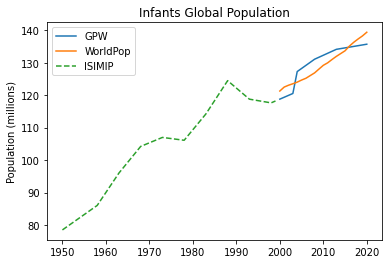

In [56]:
import matplotlib.pyplot as plt


infants_isimip_sum = infants_worldpop.sum(dim=('latitude','longitude')).sel(year=slice(1950,1999))
infants_worldpop_sum = infants_worldpop.sum(dim=('latitude','longitude')).sel(year=slice(2000,2020))
infants_gpw_sum = infants_gpw.sum(dim=('latitude','longitude')).sel(year=slice(2000,2020))

fig, ax = plt.subplots(figsize=(6, 4))

# Plot GPW data
ax.plot(infants_gpw_sum.year, infants_gpw_sum.infants / 1e6, label="GPW")

# Plot WorldPop data
ax.plot(infants_worldpop_sum.year, (infants_worldpop_sum.infants) / 1e6, label="WorldPop")

# Plot ISIMIP data (dashed line before year 2000)

ax.plot(infants_isimip_sum.year, infants_isimip_sum.infants / 1e6, label="ISIMIP", linestyle='--')

ax.legend()
ax.set_title("Infants Global Population")
ax.set_ylabel("Population (millions)")

plt.savefig("../../figures/infants_worldpop_vs_gpw_global.pdf")


# Difference by country

In [26]:
from shapely.geometry import Point
import geopandas as gpd

gdf_countries = gpd.read_file(DATA_SRC / "lancet/admin_boundaries/Detailed_Boundary_ADM0")

infants_gpw_2019 = infants_gpw.sel(year=2020)

infants_gpw_2019_gdf = infants_gpw_2019.to_dataframe().reset_index()

infants_gpw_2019_gdf['adjusted_longitude'] = infants_gpw_2019_gdf['longitude'].apply(lambda x: x - 360 if x > 180 else x)

geometry = [Point(xy) for xy in zip(infants_gpw_2019_gdf.adjusted_longitude, infants_gpw_2019_gdf.latitude)]

infants_gpw_2019_gdf = gpd.GeoDataFrame(infants_gpw_2019_gdf, crs="EPSG:4326", geometry=geometry)

infants_gpw_2019_gdf = gpd.sjoin(infants_gpw_2019_gdf, gdf_countries, how="inner", predicate='within')

infants_gpw_2019_gdf_countries = infants_gpw_2019_gdf[['infants','ISO_3_CODE', 'geometry']].groupby('ISO_3_CODE').sum()

In [27]:
infants_worldpop_2019 = infants_worldpop.sel(year=2020).to_dataframe().reset_index()

infants_worldpop_2019['adjusted_longitude'] = infants_worldpop_2019['longitude'].apply(lambda x: x - 360 if x > 180 else x)

geometry = [Point(xy) for xy in zip(infants_worldpop_2019.adjusted_longitude, infants_worldpop_2019.latitude)]

infants_worldpop_2019_gdf = gpd.GeoDataFrame(infants_worldpop_2019, crs="EPSG:4326", geometry=geometry)

infants_worldpop_2019_gdf = gpd.sjoin(infants_worldpop_2019_gdf, gdf_countries, how="inner", predicate='within')

infants_worldpop_2019_countries = infants_worldpop_2019_gdf[['infants','ISO_3_CODE', 'geometry']].groupby('ISO_3_CODE').sum()

In [28]:
import copy
diff_gdf = copy.deepcopy(infants_gpw_2019_gdf_countries).rename(columns={'infants':'infants_gpw'})
diff_gdf['infants_worldpop'] = infants_worldpop_2019_countries['infants']                                                            
diff_gdf['diff (%)'] = (infants_gpw_2019_gdf_countries['infants'] - infants_worldpop_2019_countries['infants'])/infants_gpw_2019_gdf_countries['infants']*100

In [29]:
diff_gdf.loc[['USA', 'CHE', 'IND', 'CHN']]

,infants_gpw,infants_worldpop,diff (%)
ISO_3_CODE,,,
USA,3.761789e+06,4.327057e+06,-15.026574
CHE,7.754815e+04,9.046510e+04,-16.656689
IND,2.288752e+07,2.526361e+07,-10.381624
CHN,1.610088e+07,1.489555e+07,7.486126


In [10]:
diff_gdf.loc[['USA', 'CHE', 'IND', 'CHN']]

,infants_gpw,infants_worldpop,diff (%)
ISO_3_CODE,,,
USA,3.769734e+06,4.202342e+06,-11.475810
CHE,7.705493e+04,8.997820e+04,-16.771507
IND,2.295551e+07,2.486351e+07,-8.311738
CHN,1.622933e+07,1.525812e+07,5.984247


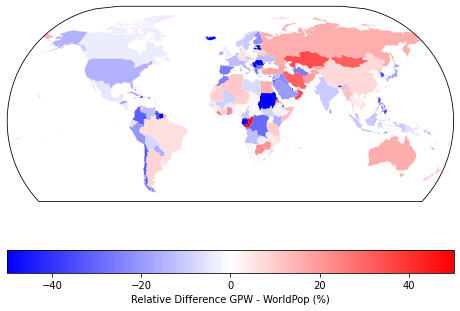

In [30]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from cartopy import crs as ccrs

MAP_PROJECTION = ccrs.EckertIII()

# Assuming gdf_countries and diff_gdf are previously defined and populated

# Reset index of diff_gdf if needed and merge it with gdf_countries
diff_gdf = pd.merge(gdf_countries[['geometry', 'ISO_3_CODE']], diff_gdf.reset_index())
diff_gdf = gpd.GeoDataFrame(diff_gdf, geometry=diff_gdf.geometry)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw=dict(projection=MAP_PROJECTION))  # You can adjust the dimensions as needed

# Plotting the data with specified vmin and vmax
diff_gdf.plot('diff (%)', vmin=-50, vmax=50, ax=ax, cmap='bwr', transform=ccrs.PlateCarree())

# Create a ScalarMappable with the colormap and norm specified
norm = mcolors.Normalize(vmin=-50, vmax=50)
cbar = plt.cm.ScalarMappable(cmap='bwr', norm=norm)

# Add the colorbar to the figure based on the ScalarMappable
fig.colorbar(cbar, ax=ax, orientation='horizontal').set_label('Relative Difference GPW - WorldPop (%)')  # Customize your label here

# Save the figure
plt.savefig("../../figures/infants_worldpop_vs_gpw_by_country.pdf")


# Over 65

In [12]:
elderly_gpw = xr.open_dataset(POP_DATA_SRC / 'hybrid_2023' / f"demographics_hybrid_1950_2020_15_min_era_compat.nc").sel(age_band_lower_bound=65)


In [13]:
elderly_worldpop = xr.open_dataset( POP_DATA_SRC / 'hybrid_2024' / f'worldpop_elderly_1950_2023_era5_compatible.nc')

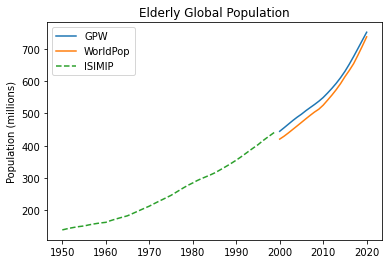

In [53]:
import matplotlib.pyplot as plt


elderly_isimip_sum = elderly_worldpop.sum(dim=('latitude','longitude')).sel(year=slice(1950,1999))
elderly_worldpop_sum = elderly_worldpop.sum(dim=('latitude','longitude')).sel(year=slice(2000,2020))
elderly_gpw_sum = elderly_gpw.sum(dim=('latitude','longitude')).sel(year=slice(2000,2020))

fig, ax = plt.subplots(figsize=(6, 4))

# Plot GPW data
ax.plot(elderly_gpw_sum.year, elderly_gpw_sum.demographic_totals / 1e6, label="GPW")

# Plot WorldPop data
ax.plot(elderly_worldpop_sum.year, (elderly_worldpop_sum.elderly) / 1e6, label="WorldPop")

# Plot ISIMIP data (dashed line before year 2000)

ax.plot(elderly_isimip_sum.year, elderly_isimip_sum.elderly / 1e6, label="ISIMIP", linestyle='--')

ax.legend()
ax.set_title("Elderly Global Population")
ax.set_ylabel("Population (millions)")

plt.savefig("../../figures/elderlies_worldpop_vs_gpw_global.pdf")


In [31]:
from shapely.geometry import Point
import geopandas as gpd

elderly_gpw_2019 = elderly_gpw.sel(year=2020)  # Assuming 'elderly_gpw' is your data variable for the elderly population

elderly_gpw_2019_gdf = elderly_gpw_2019.to_dataframe().reset_index()

elderly_gpw_2019_gdf['adjusted_longitude'] = elderly_gpw_2019_gdf['longitude'].apply(lambda x: x - 360 if x > 180 else x)

geometry = [Point(xy) for xy in zip(elderly_gpw_2019_gdf.adjusted_longitude, elderly_gpw_2019_gdf.latitude)]

elderly_gpw_2019_gdf = gpd.GeoDataFrame(elderly_gpw_2019_gdf, crs="EPSG:4326", geometry=geometry)

elderly_gpw_2019_gdf = gpd.sjoin(elderly_gpw_2019_gdf, gdf_countries, how="inner", predicate='within')

elderly_gpw_2019_gdf_countries = elderly_gpw_2019_gdf[['demographic_totals','ISO_3_CODE', 'geometry']].groupby('ISO_3_CODE').sum()


In [32]:
elderly_worldpop_2019 = elderly_worldpop.sel(year=2020).to_dataframe().reset_index()

elderly_worldpop_2019['adjusted_longitude'] = elderly_worldpop_2019['longitude'].apply(lambda x: x - 360 if x > 180 else x)

geometry = [Point(xy) for xy in zip(elderly_worldpop_2019.adjusted_longitude, elderly_worldpop_2019.latitude)]

elderly_worldpop_2019_gdf = gpd.GeoDataFrame(elderly_worldpop_2019, crs="EPSG:4326", geometry=geometry)

elderly_worldpop_2019_gdf = gpd.sjoin(elderly_worldpop_2019_gdf, gdf_countries, how="inner", predicate='within')

elderly_worldpop_2019_countries = elderly_worldpop_2019_gdf[['elderly','ISO_3_CODE', 'geometry']].groupby('ISO_3_CODE').sum()


In [33]:
import copy
diff_gdf = copy.deepcopy(elderly_gpw_2019_gdf_countries)

import copy
diff_gdf = copy.deepcopy(elderly_gpw_2019_gdf_countries).rename(columns={'demographic_totals':'elderly_gpw'})
diff_gdf['elderly_worldpop'] = elderly_worldpop_2019_countries['elderly']                                                            
diff_gdf['diff (%)'] = (elderly_gpw_2019_gdf_countries['demographic_totals'] - elderly_worldpop_2019_countries['elderly'])/elderly_gpw_2019_gdf_countries['demographic_totals']*100


In [20]:
diff_gdf.loc[['USA', 'CHE', 'IND', 'CHN', 'FRA', 'AUS']]

,elderly_gpw,elderly_worldpop,diff (%)
ISO_3_CODE,,,
USA,5.075335e+07,5.011332e+07,1.261071
CHE,1.424895e+06,1.590435e+06,-11.617691
IND,9.058412e+07,8.467862e+07,6.519351
CHN,1.740893e+08,1.631075e+08,6.308102
FRA,1.282073e+07,1.287994e+07,-0.461799
AUS,3.728445e+06,2.820046e+06,24.364029


In [34]:
diff_gdf.loc[['USA', 'CHE', 'IND', 'CHN', 'FRA', 'AUS', 'DEU']]

,elderly_gpw,elderly_worldpop,diff (%)
ISO_3_CODE,,,
USA,52399736.0,5.265650e+07,-0.490010
CHE,1455456.0,1.650655e+06,-13.411510
IND,94337552.0,8.902992e+07,5.626214
CHN,182059360.0,1.709543e+08,6.099699
FRA,13095784.0,1.325607e+07,-1.223928
AUS,3845724.5,2.884528e+06,24.993900
DEU,16980478.0,1.688102e+07,0.585720


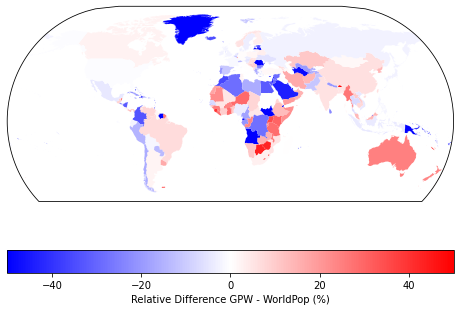

In [35]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming gdf_countries and diff_gdf are previously defined and populated

# Reset index of diff_gdf if needed and merge it with gdf_countries
diff_gdf = pd.merge(gdf_countries[['geometry', 'ISO_3_CODE']], diff_gdf.reset_index())
diff_gdf = gpd.GeoDataFrame(diff_gdf, geometry=diff_gdf.geometry)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw=dict(projection=MAP_PROJECTION))  # You can adjust the dimensions as needed

# Plotting the data with specified vmin and vmax
diff_gdf.plot('diff (%)', vmin=-50, vmax=50, ax=ax, cmap='bwr', transform=ccrs.PlateCarree())

# Create a ScalarMappable with the colormap and norm specified
norm = mcolors.Normalize(vmin=-50, vmax=50)
cbar = plt.cm.ScalarMappable(cmap='bwr', norm=norm)

# Add the colorbar to the figure based on the ScalarMappable
fig.colorbar(cbar, ax=ax, orientation='horizontal').set_label('Relative Difference GPW - WorldPop (%)')  # Customize your label here

# Save the figure
plt.savefig("../../figures/elderlies_worldpop_vs_gpw_by_country.pdf")
